# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
import talos as ta
from talos.model import lr_normalizer, early_stopper, hidden_layers

import tensorflow as tf
if tf.test.is_gpu_available() & tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow {} includes GPU support.\n".format(tf.__version__))
    #from tensorflow.python.client import device_lib
    #print(device_lib.list_local_devices())

tf.compat.v1.disable_v2_behavior()
    
from tensorflow.compat.v1.keras import callbacks, backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.utils import multi_gpu_model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, Nadam, RMSprop, SGD, Adagrad
from keras.layers.advanced_activations import ReLU, LeakyReLU

from datetime import datetime
import pandas as pd
import numpy as np

from numpy.random import seed
seed(1)
#from tensorflow.random import set_seed
tf.random.set_seed(1)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


The installed version of TensorFlow 2.0.0 includes GPU support.

Instructions for updating:
non-resource variables are not supported in the long term


# Hilfsfunktionen

### Benutzerdefinierte Kostenfunktion & Metrik

In [3]:
def circular_mse(y_true, y_pred):
    max_error = tf.constant(360, dtype='float32')
    return K.mean(K.square(K.minimum(K.abs(y_pred - y_true), max_error - K.abs(y_pred - y_true))), axis=-1)

def circular_mae(y_true, y_pred):
    max_error = tf.constant(360, dtype='float32')
    return K.mean(K.minimum(K.abs(y_pred - y_true), K.abs(max_error - K.abs(y_pred - y_true))), axis=-1)

### Generierung Datenpipeline

In [4]:
def create_data(mode):
    
    if mode == 'Synthetic' or mode == 'Mixed':
        df = pd.read_csv(_CSV_FILE)
        df_shuffled = df.sample(frac=1, random_state=1)
        df_test = df_shuffled[df_shuffled.shape[0] - 10000:df_shuffled.shape[0]]
    
        # Mixed Testdata
        if mode == 'Mixed':
            df_real = pd.read_csv(_CSV_FILE_REAL)
            df_shuffled_real = df_real.sample(frac=1, random_state=1)
            df_test_real = df_shuffled_real[df_shuffled_real.shape[0] - 61:df_shuffled_real.shape[0]]
            df_test = df_test.drop(df_test.index[0:61])
            df_test = df_test.append(df_test_real)
        
    # Real Testdata only
    elif mode == 'Real':
        df_real = pd.read_csv(_CSV_FILE_REAL)
        df_shuffled_real = df_real.sample(frac=1, random_state=1)
        df_test_real = df_shuffled_real[df_shuffled_real.shape[0] - 61:df_shuffled_real.shape[0]]
        df_test = df_test_real

    test_data_generator = ImageDataGenerator(rescale=1./255)

    test_generator = test_data_generator.flow_from_dataframe(
        dataframe=df_test
        ,directory=_IMAGE_DIR
        ,x_col='Filename'
        ,y_col=['Elevation', 'Azimuth']
        ,class_mode='multi_output'
        ,target_size=(224, 224)
        ,shuffle=False
        ,batch_size=1
    )
    
    return test_generator, df_test

### Generierung Modell (Finetuning VGG16 Block5)

In [5]:
def model_predict():
    
    K.clear_session()
    
    test_generator, df_test = create_data(_DATA_TO_USE)

    model = Sequential()
    cnn = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in cnn.layers[:15]:
        layer.trainable = False
        #print(layer.name, layer.trainable)
    
    model.add(cnn)
    
    fc = Sequential()
    fc.add(Flatten(input_shape=model.output_shape[1:])) # (7, 7, 512)
    
    if _ACTIVATION == 'leakyrelu':
        activation_layer = LeakyReLU(alpha=_LEAKY_ALPHA)
    elif _ACTIVATION == 'relu':
        activation_layer = ReLU()  

    fc.add(Dense(units=_FIRST_NEURON, kernel_initializer=glorot_uniform(seed=1)))
    fc.add(activation_layer)
    if _DROPOUT_RATE > 0.0:
        fc.add(Dropout(rate=_DROPOUT_RATE))

    hidden_neuron_fraction = _FIRST_NEURON
    for i in range(_HIDDEN_LAYERS):
        hidden_neuron_fraction = hidden_neuron_fraction // 2
        fc.add(Dense(units=hidden_neuron_fraction, kernel_initializer=glorot_uniform(seed=1)))
        fc.add(activation_layer)
        if _DROPOUT_RATE > 0.0:
            fc.add(Dropout(rate=_DROPOUT_RATE))

    fc.add(Dense(units=2, kernel_initializer=glorot_uniform(seed=1)))
    
    model.add(fc)
    model.load_weights(_MODEL_TO_LOAD)

    model.compile(
        optimizer=_OPTIMIZER(lr=_LEARNING_RATE)
        ,loss=circular_mse if(_LOSS == 'CMSE') else 'mean_squared_error'
        ,metrics=[circular_mae]
    )

    test_generator.reset()
    
    startTime = datetime.now()
    predictions = model.predict_generator(
        generator=test_generator
        ,steps=test_generator.n//test_generator.batch_size
        ,verbose=0
    )
    print("Time taken:", datetime.now() - startTime)

    del model
    return predictions, df_test

# Parameter

### Dateisystem

In [6]:
_RUN = '03'
_LOSS = 'MSE'
_DATASET_NAME = 'Dataset_2019-08-13'

In [7]:
_DATA_TO_USE = 'Real' # Synthetic (10.000), Real (61), Mixed (10.000)
_BASE_DIR = 'Top_1_DA_Mixed'

In [8]:
_IMAGE_DIR = '..\\data-target\\datasets\\{}\\'.format(_DATASET_NAME)
_CSV_FILE = _IMAGE_DIR + 'images.csv'
_CSV_FILE_REAL = _IMAGE_DIR + 'images_real.csv'

_MODEL_DIR = '..\\models-target\\{}_Regression_{}\\{}\\Train\\'.format(_RUN, _LOSS, _BASE_DIR)
_LOG_DIR = '..\\models-target\\{}_Regression_{}\\{}\\Test\\{}\\'.format(_RUN, _LOSS, _BASE_DIR, _DATA_TO_USE)

assert(os.path.exists(_LOG_DIR)) == False, 'Vorsicht, das Verzeichnis {} existiert bereits!'.format(_LOG_DIR)
os.makedirs(_LOG_DIR)

AssertionError: Vorsicht, das Verzeichnis ..\models-target\03_Regression_MSE\Top_1_DA_Mixed\Test\Real\ existiert bereits!

### CCN-Gewichte

In [9]:
df = pd.read_csv(_MODEL_DIR + 'Talos_Results_Fine.csv').drop(columns=['round_epochs', 'epochs'], axis=0)
df = df.sort_values('val_circular_mae', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
df.head()

,val_loss,val_circular_mae,loss,circular_mae,lr,activation,batch_size,dropout,first_neuron,hidden_layers,leaky_alpha,lr.1,optimizer,samples,Base
0,482.918812,7.024163,352.090888,9.863087,1.000000e-08,leakyrelu,64,0.25,1024,2,0.1,1,<class 'keras.optimizers.Adam'>,100000,0


In [25]:
os.listdir(_MODEL_DIR)

['CNN_Base_0_Logger_80000.csv',
 'CNN_Base_0_Model_and_Weights_80000.hdf5',
 'Talos_Results_Fine.csv']

In [10]:
_MODEL_TO_LOAD = _MODEL_DIR + 'CNN_Base_0_Model_and_Weights_80000.hdf5'

### Hyperparameter

In [11]:
_LEARNING_RATE = 1e-7
_DROPOUT_RATE = 0.25
_FIRST_NEURON = 1024
_HIDDEN_LAYERS = 2
_OPTIMIZER = Adam
_ACTIVATION = 'leakyrelu'
_LEAKY_ALPHA = 0.1

# Start Prognose

In [12]:
predictions, df_test = model_predict()

Found 61 validated image filenames.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Time taken: 0:00:05.418437


# Auswertung

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
base_color = (0/255, 185/255, 249/255)

In [14]:
num_predictions = df_test.shape[0]
df_result = pd.DataFrame({'Filename': df_test['Filename'][0:num_predictions],
                          'Elevation_true': df_test['Elevation'][0:num_predictions],
                          'Elevation_pred':[elem for elem in predictions[:,0]],
                          'Elevation_err': None,
                          'Azimuth_true': df_test['Azimuth'][0:num_predictions],
                          'Azimuth_pred': [elem for elem in predictions[:,1]],
                          'Azimuth_err': None,}
                        )

In [15]:
err_ele_sum = 0
err_azi_sum = 0

for index, row in df_result.iterrows():
    err_ele = abs((row['Elevation_pred'] - row['Elevation_true']))
    df_result.at[index, 'Elevation_err'] = err_ele
    err_ele_sum = err_ele_sum + err_ele
        
    err_azi = min(abs(row['Azimuth_pred'] - row['Azimuth_true']), abs(360 - abs(row['Azimuth_pred'] - row['Azimuth_true'])))
    df_result.at[index, 'Azimuth_err'] = err_azi
    err_azi_sum = err_azi_sum + err_azi
    
err_ele_avg = err_ele_sum/num_predictions
err_azi_avg = err_azi_sum/num_predictions
    
print('Fehler Elevation: {}'.format('%.3f'%err_ele_avg))
print('Fehler Azimut: {}'.format('%.2f'%err_azi_avg))

df_result.to_csv(_LOG_DIR + 'Prognosen_ErrE_{}_ErrA_{}.csv'.format('%.2f'%err_ele_avg, '%.2f'%err_azi_avg), index=False)
df_result.head()

Fehler Elevation: 6.271
Fehler Azimut: 14.12


,Filename,Elevation_true,Elevation_pred,Elevation_err,Azimuth_true,Azimuth_pred,Azimuth_err
297,box_298.jpg,58.235334,62.164536,3.9292,108.102696,104.447403,3.65529
621,bunny_219.jpg,52.267073,52.850559,0.583486,41.093280,49.144962,8.05168
336,box_337.jpg,58.539458,52.357635,6.18182,44.853371,45.057190,0.203819
26,box_27.jpg,44.315922,51.256252,6.94033,122.361229,133.645615,11.2844
588,bunny_186.jpg,50.491711,56.185268,5.69356,174.093295,179.656128,5.56283


### Durchschnittlicher Winkelfehler Azimut in Abhängigkeit Elevationswinkel

In [16]:
df_err_azi = pd.DataFrame(data=None, index=None, columns=['Elevationswinkel', 'Winkelfehler Azimut'])
for j in np.arange(5, 95, 5):
    err_azi = 0
    counter = 0
    for i in range(num_predictions):
        if df_result.iloc[i]['Elevation_true'] == j:
            counter = counter + 1
            err_azi = err_azi + df_result.iloc[i]['Azimuth_err']
    print(df_result)
    df_err_azi = df_err_azi.append(pd.DataFrame(data=[[j, err_azi/counter]],
                                                index=None,
                                                columns=['Elevationswinkel', 'Winkelfehler Azimut']))
    
df_err_azi.to_csv(_LOG_DIR + 'Winkelfehler_Azimut_in_Abhängigkeit_Elevationswinkel.csv', index=False)

          Filename  Elevation_true  Elevation_pred Elevation_err  \
297    box_298.jpg       58.235334       62.164536        3.9292   
621  bunny_219.jpg       52.267073       52.850559      0.583486   
336    box_337.jpg       58.539458       52.357635       6.18182   
26      box_27.jpg       44.315922       51.256252       6.94033   
588  bunny_186.jpg       50.491711       56.185268       5.69356   
..             ...             ...             ...           ...   
715  bunny_313.jpg       55.632891       59.121437       3.48855   
767  bunny_365.jpg       59.589930       57.685139       1.90479   
72      box_73.jpg       53.698391       48.936665       4.76173   
235    box_236.jpg       59.299465       53.159412       6.14005   
37      box_38.jpg       43.417552       41.696335       1.72122   

     Azimuth_true  Azimuth_pred Azimuth_err  
297    108.102696    104.447403     3.65529  
621     41.093280     49.144962     8.05168  
336     44.853371     45.057190    0.203819  

ZeroDivisionError: division by zero

TypeError: no numeric data to plot

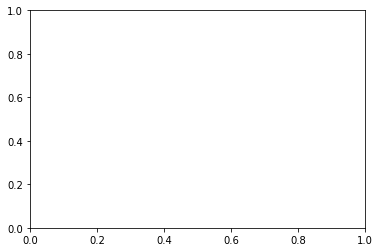

In [17]:
ax = plt.gca()
df_err_azi.plot(x='Elevationswinkel'
                ,y='Winkelfehler Azimut'
                ,kind='bar'
                ,ax=ax
                 ,color=base_color
                ,legend=False
               )

plt.title('Winkelfehler Azimut in Abhängigkeit Elevationswinkel')
plt.xlabel('Elevationswinkel')
plt.ylabel('Ø Winkelfehler Azimut (Grad)')
#plt.legend(['Training','Validierung'], loc='upper right')
plt.grid(which='major', axis='y')
#plt.xscale('log')
#plt.xticks((0,10,20,50,100), (0,10,20,50,100))
plt.yscale('log')
plt.yticks([1, 2, 4, 6, 10, 20, 40, 70], [1, 2, 4, 6, 10, 20, 40, 70])
plt.savefig(_LOG_DIR + 'Winkelfehler_Azimut_in_Abhängigkeit_Elevationswinkel.pdf', format='pdf')

### Durchschnittlicher Winkelfehler pro Modell

In [22]:
df_err_obj = pd.DataFrame(data=None, index=None, columns=['Anzahl', 'Modell', 'Azimut', 'Elevation'])
for obj in ['Box', 'Buddha', 'Bunny', 'Cone', 'Sphere']:#, 'box', 'bunny', 'ball']:
    err_azi_sum = 0
    err_ele_sum = 0
    counter = 0
    for i in range(num_predictions):
        if obj in df_result.iloc[i]['Filename']:
            counter = counter + 1
            err_azi_sum = err_azi_sum + df_result.iloc[i]['Azimuth_err']
            err_ele_sum = err_ele_sum + df_result.iloc[i]['Elevation_err']
    print(df_result)
    df_err_obj = df_err_obj.append(pd.DataFrame(
        data=[['%.0f'%counter, obj, err_azi_sum/counter, err_ele_sum/counter]],
        index=None,
        columns=['Anzahl', 'Modell', 'Azimut', 'Elevation']))

df_err_obj.to_csv(_LOG_DIR + 'Winkelfehler_in_Abhängigkeit_Modelle.csv', index=False)

KeyError: 60

TypeError: no numeric data to plot

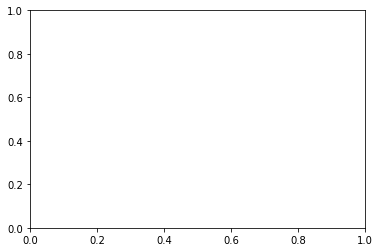

In [23]:
ax = plt.gca()
df_err_obj.plot(x='Modell',kind='bar',ax=ax, color=[base_color, 'gray'], use_index=True)

plt.title('Winkelfehler pro Modell')
plt.ylabel('Ø Winkelfehler (Grad)')
#plt.xlabel(False)
plt.legend(['Azimut','Elevation'], loc='best', frameon=True)
plt.grid(which='major', axis='y')
#plt.xscale('log')
plt.xticks(rotation=0)
#plt.yscale('log')
#plt.yticks([0, 2, 4, 6, 7.5], [0, 2, 4, 6])
plt.savefig(_LOG_DIR + 'Winkelfehler_in_Abhängigkeit_Modelle.pdf', format='pdf')